# Classification II: Logistic Regression

**OBJECTIVES**:

- Differentiate between *Regression* and *Classification* problem settings
- Connect Least Squares methods to Classification through Logistic Regression
- Interpret coefficients of the model in terms of probabilities
- Discuss performance of classification model in terms of accuracy
- Understand the effect of an imbalanced target class on model performance

In [126]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from scipy import stats

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer, load_digits, load_iris
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline

### Our Motivating Example

Use the form [here](https://forms.gle/qqkwpE3ZXPkEH1NF7) while you work through the notebook.

In [127]:
default = pd.read_csv('https://raw.githubusercontent.com/jfkoehler/nyu_bootcamp_fa25/refs/heads/main/data/Default.csv', index_col = 0)

In [128]:
default.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 1 to 10000
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   default  10000 non-null  object 
 1   student  10000 non-null  object 
 2   balance  10000 non-null  float64
 3   income   10000 non-null  float64
dtypes: float64(2), object(2)
memory usage: 390.6+ KB


In [129]:
default.head(2)

default student     balance        income
1      No      No  729.526495  44361.625074
2      No     Yes  817.180407  12106.134700

### Visualizing Default by Continuous Features

In [130]:
#scatterplot of balance vs. income colored by default status

<Axes: xlabel='balance', ylabel='income'>

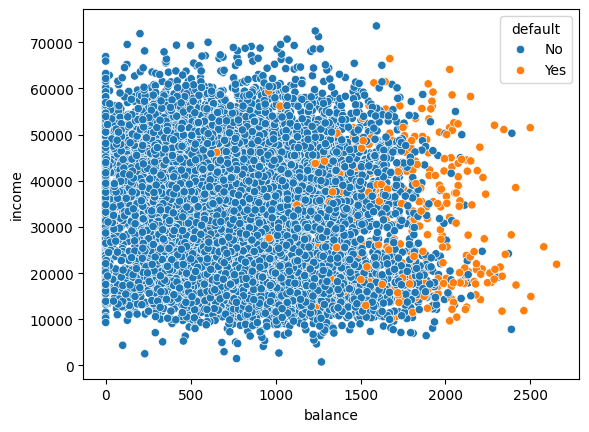

In [131]:
sns.scatterplot(data = default, x = 'balance', y = 'income', hue = 'default')

### Considering only `balance` as the predictor



In [132]:
#create binary default column
default['binary_default'] = np.where(default['default'] == 'No', 0, 1)

<Axes: xlabel='balance', ylabel='binary_default'>

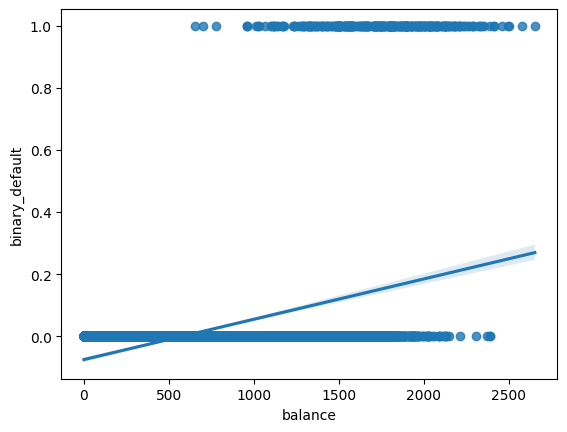

In [133]:
#scatter of Balance vs Default
sns.regplot(data = default, x = 'balance', y = 'binary_default')

### The Sigmoid aka Logistic Function


$$y = \frac{1}{1 + e^{-(\beta_0 + \beta_1 x)}}$$

In [134]:
#domain
x = np.arange(0, 2800, .1)

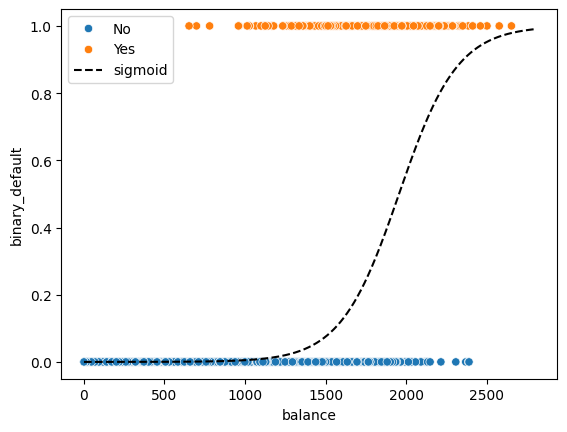

In [135]:
sns.scatterplot(data = default, x = 'balance', y = 'binary_default', hue = 'default')
plt.plot(x, 1/(1 + np.exp(-0.0055*x +10.76105259)), '--', color = 'black', label = 'sigmoid')
plt.legend();

In [136]:
def make_plot(m,b):
    sns.scatterplot(data = default, x = 'balance', y = 'binary_default', hue = 'default')
    plt.plot(x, 1/(1 + np.exp(-m*x +b)), '--', color = 'black', label = 'sigmoid')
    plt.legend();

In [137]:
interact(make_plot, m = widgets.FloatSlider(description = r'$\beta_1$', min = 0, max = 0.1, step = 0.001),
         b = widgets.FloatSlider(description = r'$\beta_0$', min = 9, max = 11, step = 0.1));

interactive(children=(FloatSlider(value=0.0, description='$\\beta_1$', max=0.1, step=0.001), FloatSlider(value…

### Example: Hypothetical Models

Below, the array `y` represents a target of true values and `yhat1` and `yhat2` represent two different model predictions.  Which model's predictions are better?

In [138]:
y = np.array([1, 1, 1, 0, 0])
yhat1 = np.array([1, 0, 0, 0, 1])
yhat2 = np.array([1, 1, 1, 1, 0])

In [139]:
pd.DataFrame({'y': y, 'yhat1': yhat1, 'yhat2': yhat2})

y  yhat1  yhat2
0  1      1      1
1  1      0      1
2  1      0      1
3  0      0      1
4  0      1      0

### Quantifying Loss

In regression, we understood the `LinearRegression` model as one seeking to minimize the mean squared error of a linear model with different slope and intercept.  With classification, we can also understand the quality of a model given an objective or **loss** function.  One such classification loss functions is **log loss** and through minimizing this loss with our sigmoid model we get the **Logistic Regression** model.

$$
\text{Log Loss or Cross Entropy}: \ell_{k}=-y_{k}\ln p_{k}-(1-y_{k})\ln(1-p_{k})
$$

In [140]:
from sklearn.metrics import log_loss

In [141]:
log_loss(y, yhat1)

21.626192033470293

In [142]:
log_loss(y, yhat2)

7.20873067782343

### Usage should seem familiar

Fit a `LogisticRegression` estimator from `sklearn` on the features:

```python 
X = default[['balance']]
y = default['binary_default']
```

In [143]:
#instantiate
clf = LogisticRegression()

In [144]:
#define X and y
X = default[['balance']]
y = default['default']

In [145]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 22)

In [146]:
#fit on the train
clf.fit(X_train, y_train)

LogisticRegression()

In [147]:
#examine train and test scores
print(f'Train Accuracy: {clf.score(X_train, y_train)}')
print(f'Test Accuracy: {clf.score(X_test, y_test)}')

Train Accuracy: 0.9728
Test Accuracy: 0.9712


### Evaluating the Classifier

In `scikitlearn` the primary default evalution metric is **accuracy** or percent correct.  We still need to compare this to our baseline -- typically predicting the most frequently occurring class.  Further, you can investigate the mistakes made with each class by looking at the **Confusion Matrix**.  A quick visualization of this is had using the `ConfusionMatrixDisplay`.

In [148]:
#baseline -- most frequently occurring class
y_train.value_counts(normalize = True)

default
No     0.966533
Yes    0.033467
Name: proportion, dtype: float64

In [149]:
from sklearn.metrics import ConfusionMatrixDisplay

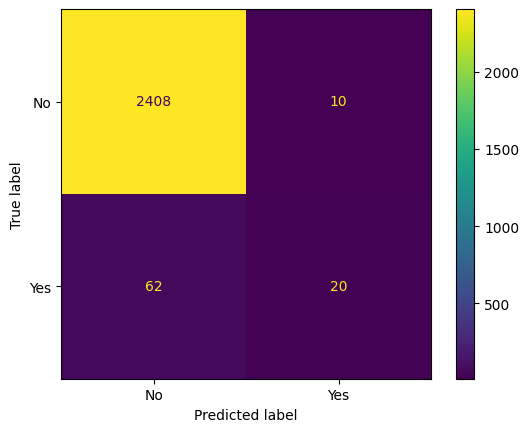

In [150]:
#from estimator
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test)

### Interpreting Output of the Model

The version of the logistic we have just developed is actually:

$$ y = \frac{e^{ax + b}}{1 + e^{ax + b}} $$

Its output represents probabilities of being labeled the positive class in our example.  This means that we can interpret the output of the above function using our parameters, remembering that we used the `balance` feature to predict `default`.

In [151]:
def predictor(x):
    line = clf.coef_[0]*x + clf.intercept_
    return np.e**line/(1 + np.e**line)

In [152]:
#predict 1000
predictor(1000)

array([0.00548355])

In [153]:
#predict 2000
predictor(2000)

array([0.58905082])

In [154]:
#estimator has this too
clf.predict_proba(np.array([[1000]]))

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


array([[0.99451645, 0.00548355]])

In [155]:
clf.predict(np.array([[1000], [2000]]))

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


array(['No', 'Yes'], dtype=object)

**PROBLEM**: Given the probability of default below, can you understand what the code is doing?  Is the model performance different?

In [156]:
#extracting probability of default from lgr
probability_default = clf.predict_proba(X)[:, 1]

In [157]:
#change the probability threshold to predict yes if greater than 30% probability
new_predictions = np.where(probability_default > .3, 'Yes', 'No')

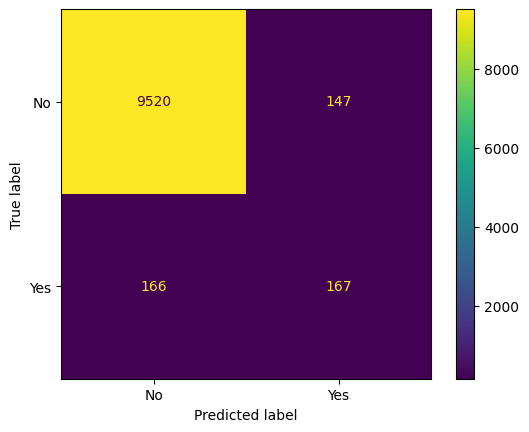

In [158]:
ConfusionMatrixDisplay.from_predictions(y, new_predictions)

In [160]:
default.head(2)

default student     balance        income  binary_default
1      No      No  729.526495  44361.625074               0
2      No     Yes  817.180407  12106.134700               0

In [174]:
ohe = OneHotEncoder(drop = 'first')

In [175]:
transformer = make_column_transformer((ohe, ['student']),
                                      remainder = StandardScaler())

In [176]:
features = ['balance', 'income', 'student']
X = default.loc[:, features]
y = default['binary_default']

In [177]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=22)

In [178]:
X_train = transformer.fit_transform(X_train)
X_test = transformer.transform(X_test)

In [179]:
clf = LogisticRegression().fit(X_train, y_train)

In [180]:
clf.score(X_train, y_train)

0.9741333333333333

In [181]:
clf.score(X_test, y_test)

0.9712

In [182]:
clf.coef_

array([[-0.66485112,  2.75243435,  0.00621226]])

In [183]:
transformer.get_feature_names_out()

array(['onehotencoder__student_Yes', 'remainder__balance',
       'remainder__income'], dtype=object)

**Predictions**:

- student: yes
- balance: 1,500 dollars
- income: 40,000 dollars

In [184]:
ex1 = np.array([[1, 1500, 40_000]])
#predict probability
clf.predict_proba(ex1)

array([[0., 1.]])

- student: no
- balance: 1,500 dollars
- income: 40,000 dollars

In [185]:
ex2 = np.array([[0, 1500, 40_000]])
#predict probability
clf.predict_proba(ex2)

array([[0., 1.]])

### This is similar to our multicollinearity in regression; we will call it confounding

<center>
<img src = 'https://github.com/jfkoehler/nyu_bootcamp_fa24/blob/main/images/default_confound.png?raw=true' />
</center>

#### Using `scikitlearn` and its `Pipeline`

From the original data, to build a model involved:

1. One hot or dummy encoding the categorical feature.
2. Standard Scaling the continuous features
3. Building Logistic model

we can accomplish this all with the `Pipeline`, where the first step is a `make_column_transformer` and the second is a `LogisticRegression`.  

In [186]:
from sklearn.pipeline import Pipeline 
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [187]:
X_train, X_test, y_train, y_test = train_test_split(default[['student', 'income', 'balance']], default['default'],
                                                   random_state = 22)

In [188]:
# create OneHotEncoder instance
ohe = OneHotEncoder(drop = 'first')

In [189]:
# create StandardScaler instance
sscaler = StandardScaler()

In [190]:
# make column transformer
transformer = make_column_transformer((ohe, ['student']), 
                                     remainder = sscaler,
                                     force_int_remainder_cols=False)

In [191]:
# logistic regressor
clf = LogisticRegression()

In [192]:
# pipeline
pipe = Pipeline([('transform', transformer), 
                 ('model', clf)])

In [193]:
# fit it
pipe.fit(X_train, y_train)

Pipeline(steps=[('transform',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder=StandardScaler(),
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='first'),
                                                  ['student'])])),
                ('model', LogisticRegression())])

In [194]:
# score on train and test
print(f'Train Score: {pipe.score(X_train, y_train)}')
print(f'Test Score: {pipe.score(X_test, y_test)}')

Train Score: 0.9741333333333333
Test Score: 0.9712


In [195]:
pipe.named_steps['model'].coef_

array([[-0.66485112,  0.00621226,  2.75243435]])

#### Problem

Below, a dataset on bank customer churn is loaded and displayed.  Your objective is to predict `Exited` or not.  Use `CreditScore`, `Gender`, `Age`, `Tenure`, and `Balance` as predictors.  Examine the confusion matrix display.  Was your classifier better at predicting exits or non-exits?

In [196]:
from sklearn.datasets import fetch_openml

In [197]:
bank_churn = fetch_openml(data_id = 43390).frame

In [198]:
bank_churn.head()

RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00              1          1               1   
1       1   83807.86              1          0               1   
2       8  159660.80              3          1               0   
3       1       0.00              2          0               0   
4       2  125510.82              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57       1  
3         93826.63       0  
4         79084.10       0

In [200]:
bank_churn.to_csv('bank_churn.csv')

In [204]:
#create train/test split -- random_state = 11
X = bank_churn.drop(columns = ['Exited', 'RowNumber', 'CustomerId', 'Surname'])
y = bank_churn['Exited']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=11)

In [206]:
y_train.value_counts(normalize = True)

Exited
0    0.7976
1    0.2024
Name: proportion, dtype: float64

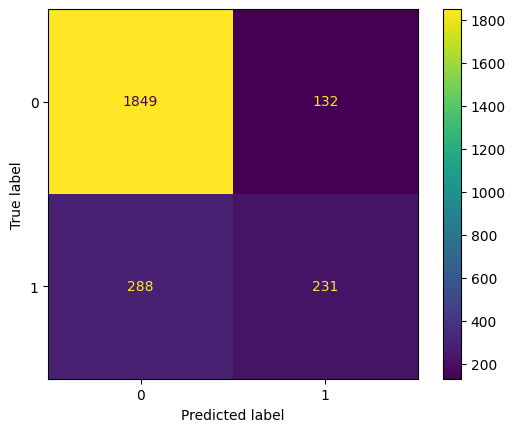

In [208]:
#make categorical features numeric
ohe = OneHotEncoder(drop = 'first')
#scale numeric features
scale = StandardScaler()
transformer = make_column_transformer((ohe, ['Geography', 'Gender']),
                        remainder=scale)
#pipeline for transform and model with logistic regression
lgr_pipe = Pipeline([('transformer', transformer), 
                     ('model', KNeighborsClassifier())])
#fit it
lgr_pipe.fit(X_train, y_train)
#visualize confusion matrix
ConfusionMatrixDisplay.from_estimator(lgr_pipe, X_test, y_test)

In [209]:
lgr_pipe.score(X_test, y_test)

0.832

#### Practice

In [ ]:
from sklearn.datasets import load_breast_cancer

In [ ]:
cancer = load_breast_cancer(as_frame=True).frame

In [ ]:
cancer.head(3)

In [ ]:
# use all features


In [ ]:
# train/test split -- random_state = 42


In [ ]:
# pipeline to scale then knn


In [ ]:
# pipeline to scale then logistic


In [ ]:
# fit knn


In [ ]:
# fit logreg


In [ ]:
# compare confusion matrices on test data
